In [11]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath("./"))
import importlib
#importlib.reload(cleaning)  # Force reload the module
import cleaning

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn import metrics


# Data Cleaning and EDA

## Clean the data
### Process of cleaning 

*Code written for cleaning in [cleaning.py](./cleaning.py).*

* We'll pass a list of the csv files from reddit into a function that cleans and concatenates the csvs into one dataframe.
    * It doesn't make much sense to keep posts that are null in the "selftext" column, so those will be removed.
    * Next, I will remove any rows where this is the case. We'll also rename the "Unnamed: 0" column to "post_id".
    * Also, we'll remove the "comments" columns. These were pulled in just in case they gave any additional information, but for now, they will be removed. They can be accessed at another time if needed. 
    * A column that assigns 0/1 values for the subreddit: 0 for the rpg subreddit, 1 for the osr subreddit will be added
    * Return the concatenated dataframe
* Once the completed dataframe is created, use "post_id" to deduplicate the data. We'll get a final count of the subreddit post totals to see if we need to pull in more data. 


In [12]:
files = [f"../data/{file}" for file in os.listdir("../data") if file.endswith(".csv")]
files.remove('../data/cleaned_df.csv')
files.remove('../data/cleaned_with_sentiment_df.csv')
files.remove("../data/reddit_cleaned_df.csv")
files

['../data/rpg_0-999.csv',
 '../data/osr_244-489.csv',
 '../data/rpg_1000-1150.csv',
 '../data/osr_1931-2163.csv',
 '../data/osr_1683-1931.csv',
 '../data/rpg_1150-1394.csv',
 '../data/osr_0-243.csv',
 '../data/osr1_245-490.csv',
 '../data/rpg_1394-1628.csv',
 '../data/osr_490-1190.csv',
 '../data/osr_1190-1433.csv',
 '../data/rpg_1628-1862.csv',
 '../data/osr_1433-1683.csv']

In [13]:
cleaned = cleaning.clean_data(files)

/Users/bolanle/Desktop/dsb-210/projects/project-3/code/cleaning.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_df = pd.concat([concat_df, df])


In [32]:
cleaned.head()

,post_id,title,selftext,subreddit,created_utc,is_osr,text_len,word_count
0,1idq440,PLEASE NOTE: The Punch a Nazi rpg post from ea...,The post was apparently reported to Reddit Adm...,rpg,1.738253e+09,0,227,33
1,1i8dnf4,Twitter/X links are now banned on /r/rpg,We don't see Twitter/X links on here very ofte...,rpg,1.737665e+09,0,557,80
2,1i7d4mj,Proposal to ban x.com links,"I wonder if the moderators will consider, as o...",rpg,1.737558e+09,0,110,17
3,4wuhj4,I figured out why I hated Suicide Squad so muc...,Suicide Squad spoilers ahoy:\n\n...\n\n...\n\n...,rpg,1.470719e+09,0,3335,613
7,1iejv8i,"We Win, Nazi's Lose!",Apparently we raised enough of a stink that th...,rpg,1.738344e+09,0,2036,276


In [33]:
cleaned = cleaned.drop_duplicates(subset="post_id")

In [77]:
cleaned["is_osr"].value_counts()


is_osr
1    1145
0    1102
Name: count, dtype: int64

In [75]:
cleaned.shape
cleaned.head()
cleaned.tail()
cleaned = cleaned.reset_index()
cleaned.tail()


ValueError: cannot insert level_0, already exists

In [80]:
cleaned["is_osr"]=cleaned["is_osr"].astype(int)

#### There are at least 1000 posts from each subreddit, so the dataframe can saved.

In [53]:
cleaned.to_csv("../data/reddit_cleaned_df.csv")

## EDA
#### Now that there is a dataframe with our reddit data, let's explore it a bit.

In [54]:
cleaned["is_osr"].value_counts(normalize=True) 

is_osr
1    0.509568
0    0.490432
Name: proportion, dtype: float64

### Baseline Accuracy
Our baseline accuracy is 50.9% that subreddit will be from the osr subreddit. First, let's normalize our text by our tokenizing, lemmatizing, stemming, and  removing special characters and stop words.


### We'll use TF-IDF Vectorizer
This is going to vectorize our data and weigh the importance of the words in our documents. TF-IDF Vectorizer does not assume that words with more frequency simply have greater importance. It wiil measure the term frequency and the inverse document frequency.

Let's make a function to vectorize selftext and check out unigrams and bigrams for our subreddits, together and separately.

***Code can be found here: [cleaning.py](./cleaning.py).***

In [55]:
X = cleaned["selftext"]
y = cleaned["is_osr"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

game         169.753827
like         157.873167
one          130.755891
players      109.420497
would        105.371882
games        103.698017
rpg          103.058857
osr           96.679039
new           94.808699
play          93.630877
know          92.756169
system        91.747930
really        89.579306
time          87.598357
people        87.410170
get           85.883917
want          85.616958
rules         84.190049
think         82.706619
also          76.897092
even          74.454096
campaign      73.469415
character     71.661533
good          70.398275
something     70.173778
dtype: float64


Text(0.5, 1.0, 'Common Unigrams in Both Subreddits')

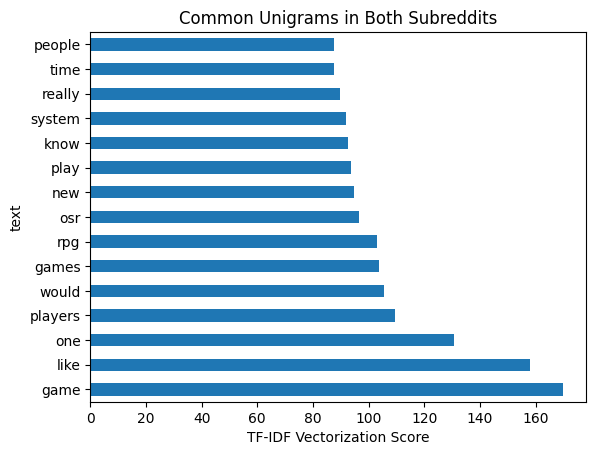

In [56]:
#clean df unigram
cleaning.tfidf_list_and_barplot(1, 1, X_train, X_test, y_train, y_test)
plt.title("Common Unigrams in Both Subreddits")

### Common unigrams in combined data: 
In the combined data we see common unigrams such as game, like, rpg, one, players. At least a few of these are a specifically meaningful like players, rpg, and game as they relate to role-playing games in an obvious way. The word one being so high is likely due to the recent release of D&D One in late 2024. 

old school            59.384074
feel like             52.351668
b x                   32.706167
years ago             32.448521
let know              26.228969
first time            25.661106
would like            25.563645
seems like            24.521717
one shot              24.468476
role playing          23.745440
character creation    23.008720
games like            22.474502
feels like            21.914398
feel free             21.879887
dungeons dragons      21.637847
things like           21.195849
would love            21.088417
one players           20.610068
really like           20.169355
3 5                   19.812679
sci fi                19.752767
three years           19.743923
looks like            18.976256
osr games             18.833871
many people           17.782554
dtype: float64


Text(0.5, 1.0, 'Common Bigrams in Both Subreddits')

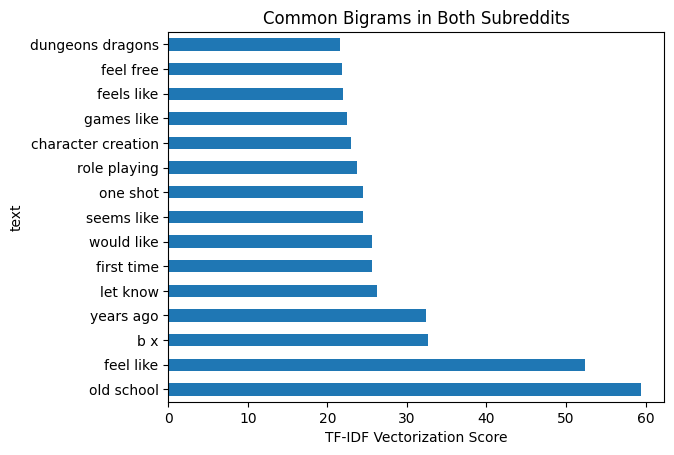

In [57]:
#cleaned df bigrams
cleaning.tfidf_list_and_barplot(2, 2, X_train, X_test, y_train, y_test)
plt.title("Common Bigrams in Both Subreddits")

### Common bigrams in combined data: 
In the combined data we see common bigrams such as old school, feel like, and years ago. This might mean that one subreddit is talking a lot about any of these bigrams. Since TF-IDF Vectorization weigh text, these words might show up in documents from one subreddit a lot. It's not unlikely that both subreddits are talking about old school games or using the phrase, "feel like". Both the rpg and osr subreddits are commonly used to request help in finding games and oftentimes role-players will seek out games that have a certain "feel" or "vibe." 

Next, we'll separate the osr and rpg data into their own dataframes so we can look at the unigrams and bigrams for each. 

In [58]:
#separate osr and rpg into their own dfs
osr_df = cleaned.loc[cleaned['is_osr'] == 1]
rpg_df = cleaned.loc[cleaned['is_osr'] == 0]


In [59]:
#osr, test train split

X1 = osr_df["selftext"]
y1 = osr_df["is_osr"]

# Train/test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, 
                                                    y1, 
                                                    random_state=123)



like         79.797044
osr          75.163202
game         70.304064
one          58.846166
new          55.439749
would        52.091610
players      49.678901
rules        46.115729
know         45.703552
really       41.517661
campaign     41.424956
system       41.293402
rpg          41.169567
play         40.438316
also         39.905281
games        39.667218
want         38.897339
dungeon      38.830563
get          37.334561
think        37.122335
good         35.791902
time         35.667305
adventure    35.548457
5e           34.525500
run          34.473845
dtype: float64


Text(0.5, 1.0, 'Common Unigrams in OSR Subreddit')

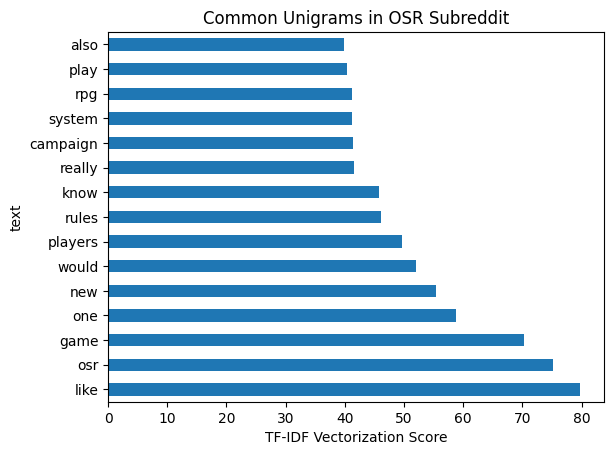

In [60]:
# osr dataframe unigrams
cleaning.tfidf_list_and_barplot(1, 1, X_train_1, X_test_1, y_train_1, y_test_1)
plt.title("Common Unigrams in OSR Subreddit")

### Common unigrams in osr data: 
We see that the words like, osr, game, one, and new show up in the osr group in heavier weight. As expected, osr it high on the list and as stated above, "like" indicates that people come to this subreddit looking for game reccomendations. It also appears that people in this subreddit are talking about the new D&D One release from late last year ("one"). They are interested in "system" and "rules" which tracks as players who like osr games typically are looking for specific game mechanics. 

old school            49.237773
b x                   34.057278
osr games             19.859519
feel like             18.395447
osr community         16.746950
years ago             14.873793
seems like            13.986029
character creation    13.346689
really like           13.341345
school essentials     13.249213
would like            13.102879
osr game              12.877339
basic fantasy         12.835250
something like        12.811236
let know              12.406099
would love            11.446000
role playing          11.217531
dungeons dragons      11.133488
one shot              11.012761
feels like            10.189479
magic items           10.005232
osr style              9.943602
random tables          9.855963
thanks advance         9.818373
campaign setting       9.782065
dtype: float64


Text(0.5, 1.0, 'Common Bigrams in OSR Subreddit')

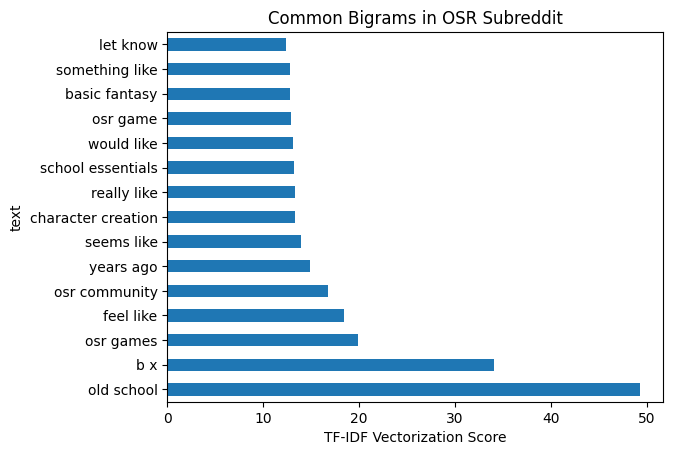

In [61]:
# osr dataframe bigrams
cleaning.tfidf_list_and_barplot(2, 2, X_train_1, X_test_1, y_train_1, y_test_1)
plt.title("Common Bigrams in OSR Subreddit")

### Common bigrams in osr data: 
The osr group talks about "old school", "b x", and "osr games". The most notable bigrams on the list are specifically "b x" and "school essentials". "B/X" is how a version of original D&D gets called by players, as that version never got an official name. "School essentials" refers to "old school essentials" which is a role-playing game system which is a modern adapatation/revision of "b x".


In [62]:
# for rpg, uni- and bigrams

# Suppose `cleaned` is your DataFrame
X2 = rpg_df["selftext"]
y2 = rpg_df["is_osr"]

# Train/test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, random_state=123)


game         96.877211
like         81.433453
one          68.846583
games        62.992848
rpg          60.058264
players      59.602230
people       56.375788
would        53.970172
play         53.102066
time         51.418817
system       49.361183
know         47.381076
want         46.608151
get          45.222645
really       44.598027
think        44.133062
character    43.461272
even         42.777434
new          41.864831
make         39.351269
gm           38.663873
something    37.805702
also         36.718921
much         36.408308
rules        35.665747
dtype: float64


Text(0.5, 1.0, 'Common Unigrams in RPG Subreddit')

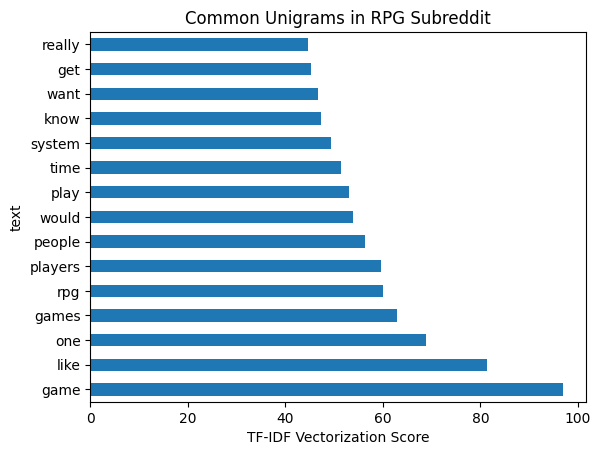

In [63]:
# osr dataframe unigrams
cleaning.tfidf_list_and_barplot(1, 1, X_train_2, X_test_2, y_train_2, y_test_2)
plt.title("Common Unigrams in RPG Subreddit");

### Common unigrams in rpg data: 
There should be no surprise that "games", "rpg", "players", "system", and "character" are heavily weighted unigrams from the rpg subreddit. These are all terms that relate to role-playing games generally. 

feel like           30.965489
years ago           18.183920
feel free           15.142168
games like          14.998719
first time          14.541405
star wars           14.037171
would like          13.893381
want play           13.649871
feels like          13.274397
one players         13.145679
call cthulhu        12.754149
one shot            12.459166
looks like          12.316121
running game        12.130669
dungeons dragons    12.015800
last year           11.990541
sci fi              11.772906
many people         11.758961
never played        11.689299
play game           11.435454
3 5                 11.385788
pretty much         11.266515
every time          11.115745
e g                 10.855161
let know            10.690047
dtype: float64


Text(0.5, 1.0, 'Common Bigrams in RPG Subreddit')

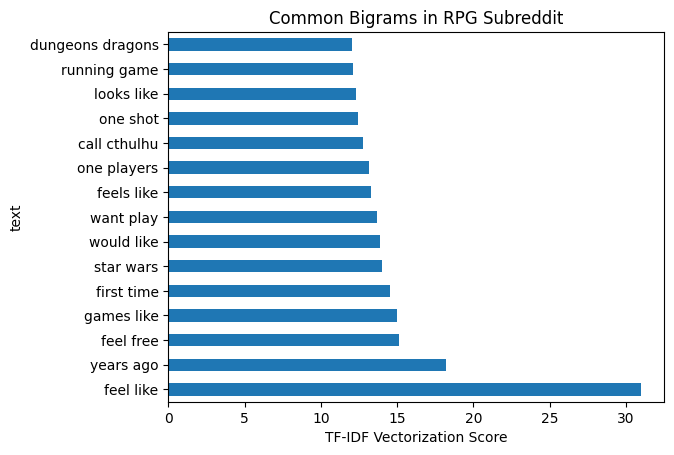

In [64]:
# rpg dataframe bigrams
cleaning.tfidf_list_and_barplot(2, 2, X_train_2, X_test_2, y_train_2, y_test_2)
plt.title("Common Bigrams in RPG Subreddit")

### Common bigrams in rpg data: 
"First time" may indicate new players of rpgs go to the subreddit or that posters are talking about their first experiences. "Years ago"  may indicate that people like talking about what they've done in the past in relation to role-playing games. Unsurpsingly, "one players" shows up as another likely reference to D&D One. "Star Wars", "sci fi", "call cthulhu" show up as popular games/genres in the role-playing space.


**Before we look at any possible numeric correlations between is_osr, let's add a few more numeric columns. We can add a word count, a character text count, and sentiment analysis columns.**

In [65]:
osr_df["text_len"] = osr_df["selftext"].str.len()
osr_df["word_count"] = osr_df["selftext"].str.split().apply(len)
osr_df.head()

rpg_df["text_len"] = rpg_df["selftext"].str.len()
rpg_df["word_count"] = rpg_df["selftext"].str.split().apply(len)
rpg_df.head()

cleaned["text_len"] = cleaned["selftext"].str.len()
cleaned["word_count"] = cleaned["selftext"].str.split().apply(len)
cleaned.head()

/var/folders/2v/ptzrdvld44b9hmth7tj5zm840000gn/T/ipykernel_42710/587546809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  osr_df["text_len"] = osr_df["selftext"].str.len()
/var/folders/2v/ptzrdvld44b9hmth7tj5zm840000gn/T/ipykernel_42710/587546809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  osr_df["word_count"] = osr_df["selftext"].str.split().apply(len)
/var/folders/2v/ptzrdvld44b9hmth7tj5zm840000gn/T/ipykernel_42710/587546809.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy

,index,post_id,title,selftext,subreddit,created_utc,is_osr,text_len,word_count
0,0,1idq440,PLEASE NOTE: The Punch a Nazi rpg post from ea...,The post was apparently reported to Reddit Adm...,rpg,1.738253e+09,0,227,33
1,1,1i8dnf4,Twitter/X links are now banned on /r/rpg,We don't see Twitter/X links on here very ofte...,rpg,1.737665e+09,0,557,80
2,2,1i7d4mj,Proposal to ban x.com links,"I wonder if the moderators will consider, as o...",rpg,1.737558e+09,0,110,17
3,3,4wuhj4,I figured out why I hated Suicide Squad so muc...,Suicide Squad spoilers ahoy:\n\n...\n\n...\n\n...,rpg,1.470719e+09,0,3335,613
4,7,1iejv8i,"We Win, Nazi's Lose!",Apparently we raised enough of a stink that th...,rpg,1.738344e+09,0,2036,276


In [66]:
sa = SentimentIntensityAnalyzer()

sentiment_data = [sa.polarity_scores(text) for text in cleaned["selftext"]]
sentiment_df = pd.DataFrame.from_dict(sentiment_data)
cleaned = pd.concat([cleaned, sentiment_df],axis=1)
cleaned.head()

,index,post_id,title,selftext,subreddit,created_utc,is_osr,text_len,word_count,neg,neu,pos,compound
0,0,1idq440,PLEASE NOTE: The Punch a Nazi rpg post from ea...,The post was apparently reported to Reddit Adm...,rpg,1.738253e+09,0,227,33,0.000,1.000,0.000,0.0000
1,1,1i8dnf4,Twitter/X links are now banned on /r/rpg,We don't see Twitter/X links on here very ofte...,rpg,1.737665e+09,0,557,80,0.068,0.872,0.060,-0.3994
2,2,1i7d4mj,Proposal to ban x.com links,"I wonder if the moderators will consider, as o...",rpg,1.737558e+09,0,110,17,0.000,1.000,0.000,0.0000
3,3,4wuhj4,I figured out why I hated Suicide Squad so muc...,Suicide Squad spoilers ahoy:\n\n...\n\n...\n\n...,rpg,1.470719e+09,0,3335,613,0.126,0.744,0.130,-0.2012
4,7,1iejv8i,"We Win, Nazi's Lose!",Apparently we raised enough of a stink that th...,rpg,1.738344e+09,0,2036,276,0.084,0.759,0.156,0.9672


In [73]:
cleaned.dtypes

index            int64
post_id         object
title           object
selftext        object
subreddit       object
created_utc    float64
is_osr          object
text_len         int64
word_count       int64
neg            float64
neu            float64
pos            float64
compound       float64
dtype: object

In [72]:
cleaned.tail()

,index,post_id,title,selftext,subreddit,created_utc,is_osr,text_len,word_count,neg,neu,pos,compound
2242,243,1j0hj6f,"When you create a dungeon, do you tend to make...",Pretty much the title. I am curious in terms o...,osr,1.740775e+09,1,214,38,0.000,0.811,0.189,0.7717
2243,244,1j0gblw,Rules/Guides For Making Stats For OSR Creatures?,I have a database of creature stats for PF2 an...,osr,1.740772e+09,1,571,97,0.021,0.841,0.138,0.8754
2244,246,1j0fy0e,Forest hazards/ traveling setbacks.,Not an OSR player but running a hex crawl for ...,osr,1.740771e+09,1,226,40,0.000,0.787,0.213,0.8573
2245,247,1j0e1wc,Improvising and riffing off of published Adven...,I'm running an old school Adventure I won't na...,osr,1.740766e+09,1,2114,400,0.059,0.794,0.148,0.9890
2246,248,1j0dwly,Seeking advice for the execution of solo/co-op...,My wife has expressed interest in giving ttrpg...,osr,1.740765e+09,1,677,132,0.058,0.729,0.213,0.9641


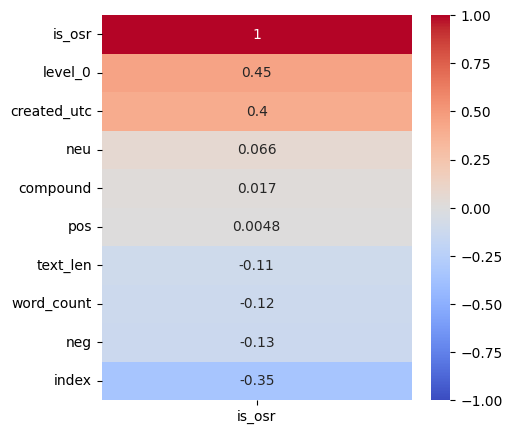

In [81]:
plt.figure(figsize=(5,5))
sns.heatmap(cleaned.corr(numeric_only=True)[["is_osr"]].sort_values(by="is_osr", ascending=False),
            annot=True,
            vmin=-1,
            vmax=1,
            cmap ="coolwarm");

# LABEL AXES ON THESE

Text(0.5, 1.0, 'When Posts Were Posted Has Some Relationship To the Subreddit')

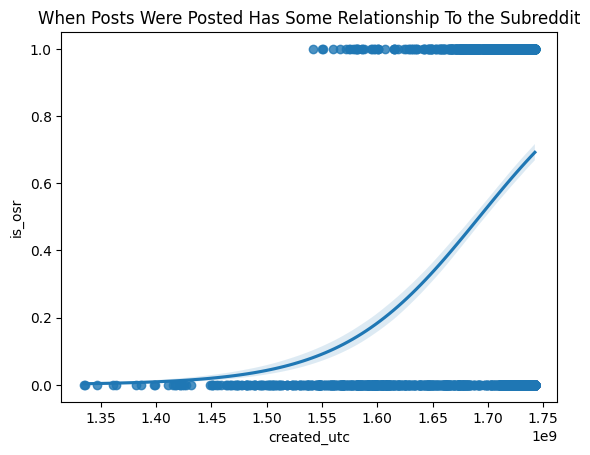

In [83]:
sns.regplot(data=cleaned, x="created_utc", y="is_osr", logistic=True);
plt.title("When Posts Were Posted Has Some Relationship To the Subreddit")

Text(0.5, 1.0, 'Negative Post Barely Has Negative Relationship To the Subreddit')

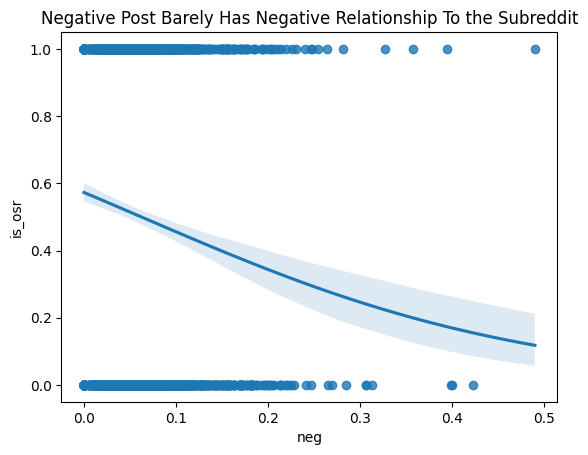

In [84]:
sns.regplot(data=cleaned, x="neg", y="is_osr", logistic=True);
plt.title("Negative Post Barely Has Negative Relationship To the Subreddit")

**Created_utc seems to have some correlation with a post being from the osr subreddit. The number of characters and words in a post do not seems to have much correlation with determining if a post came from the osr subreddit, nor does sentiment analysis. That said, I am still interested to see how some of these variables affect the model. For numeric columns, I will model the the word count, negative sentiment, and created_utc. They have the most correlation compared to the other numeric variable options. I will also run a grid search with compound sentiment instead of negative sentiment to see if it reduces variance and still creates a good scoring model.** 

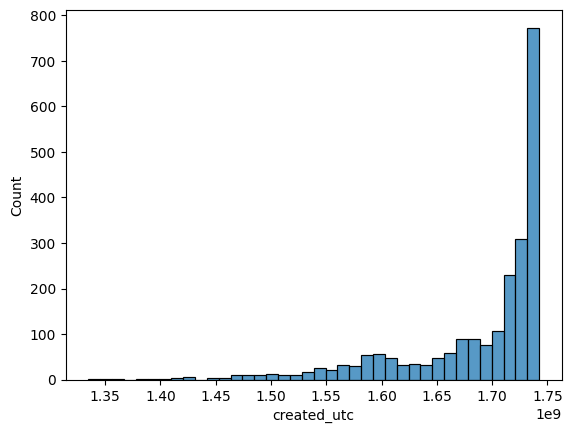

In [85]:
sns.histplot(data=cleaned, x="created_utc");

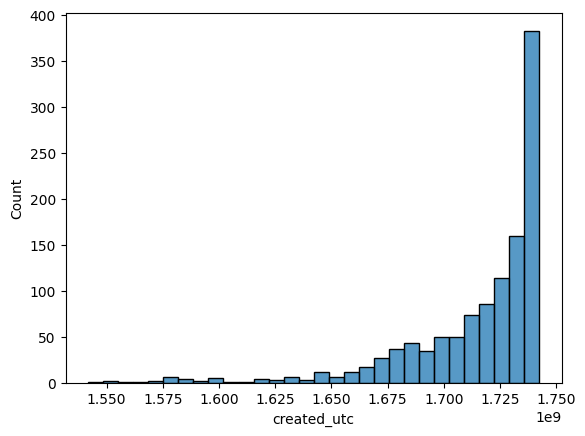

In [86]:
sns.histplot(data=osr_df, x="created_utc");

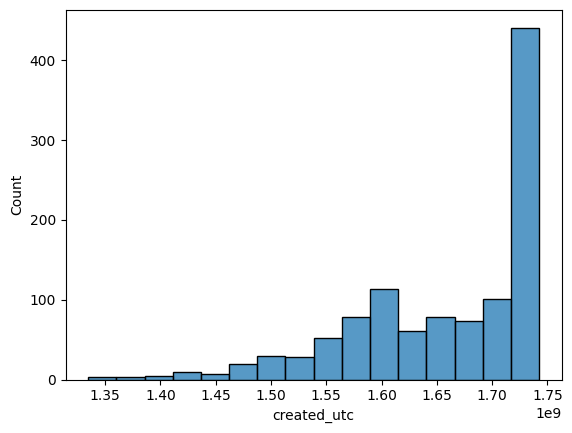

In [87]:
sns.histplot(data=rpg_df, x="created_utc");

There are more recent posts across both subreddits, though I tried to pulled data from older post as best I could, there will be bias towards posts that are more recent.

In [89]:
cleaned.describe()
osr_df.describe()
rpg_df.describe()

,index,created_utc,text_len,word_count
count,1102.000000,1.102000e+03,1102.000000,1102.000000
mean,327.129764,1.659682e+09,1455.123412,249.803993
std,288.718130,8.485067e+07,2567.775857,431.270697
min,0.000000,1.334762e+09,8.000000,1.000000
25%,102.250000,1.598693e+09,381.250000,64.250000
50%,196.500000,1.684050e+09,776.000000,132.000000
75%,545.500000,1.733247e+09,1696.750000,281.000000
max,998.000000,1.742416e+09,39517.000000,6518.000000


In [88]:
print(f"Total data avg word count: {cleaned["word_count"].mean()}")
print(f"OSR avg word count:{osr_df["word_count"].mean()}")
print(f"RPG avg word count:{rpg_df["word_count"].mean()}")

Total data avg word count: 205.68135291499777
OSR avg word count:163.21572052401746
RPG avg word count:249.80399274047187


In [90]:
clean_x =cleaned["word_count"].mean()
osr_x = osr_df["word_count"].mean()
rpg_x = rpg_df["word_count"].mean()

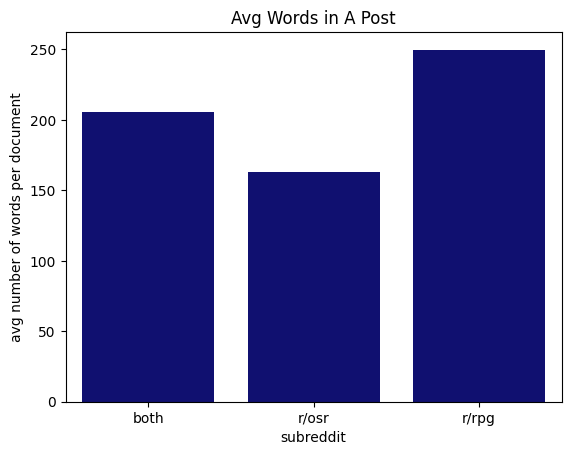

In [108]:
sns.barplot(data=[clean_x,osr_x,rpg_x],color="navy");
plt.xlabel("subreddit");
plt.xticks(([0, 1, 2]),["both", "r/osr","r/rpg"]);
plt.ylabel("avg number of words per document");
plt.title("Avg Words in A Post");

**It appears that the RPG subreddit has wordier posts on average (~ 250 words per document) when compared to the OSR subreddit (~163 words per document).**

We can't fully determine yet if finding a model with more than 75% accuracy is possible, but there are some positive signs that there are distinctive and specific words related to the individual subreddits. Additionally, there are a few numeric colummns that appear to have some moderate correlation to our target, "is_osr". This gives me great hope that a model would be able to have a high ratio of correct predictions.  

Let's go [model our data](./model_analysis_conclusion.ipynb)! We'll also analyze what we find, draw some conclusions, and make some reccomendations there.